# Bangalore Housing Price Analysis & Prediction

<b>This is my first notebook on Kaggle!</b> I have attempted to predict house prices in Bangalore using some fairly simple techniques and a bit of feature engineering, on which I would appreciate your feedback. From time to time I will also share my understanding of price drivers, outliers and limitations which arise due the absence of certain key features. I am new to programming, although I have over 18 years of experience in different industries, a lot of them in analytical roles dealing with various kinds of data. With further notebook submissions I hope to improve the quality of code!

<h3>There is not a ton of EDA here and I have focused more on approach.</h3>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [8]:
bangalore = pd.read_csv('Bangalore.csv')

In [9]:
bangalore.head()

,Unnamed: 0,Price,Area,Location,No. of Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
0,0,30000000,3340,JP Nagar Phase 1,4,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
1,1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,...,1,0,1,0,0,0,0,0,0,0
2,2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,3,8358000,1675,Doddanekundi,3,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,4,6845000,1670,Kengeri,3,0,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [10]:
bangalore.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 6207 entries, 0 to 6206
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           6207 non-null   int64 
 1   Price                6207 non-null   int64 
 2   Area                 6207 non-null   int64 
 3   Location             6207 non-null   object
 4   No. of Bedrooms      6207 non-null   int64 
 5   Resale               6207 non-null   int64 
 6   MaintenanceStaff     6207 non-null   int64 
 7   Gymnasium            6207 non-null   int64 
 8   SwimmingPool         6207 non-null   int64 
 9   LandscapedGardens    6207 non-null   int64 
 10  JoggingTrack         6207 non-null   int64 
 11  RainWaterHarvesting  6207 non-null   int64 
 12  IndoorGames          6207 non-null   int64 
 13  ShoppingMall         6207 non-null   int64 
 14  Intercom             6207 non-null   int64 
 15  SportsFacility       6207 non-null   int6

In [7]:
len(bangalore)

6207

This dataset is already available on Kaggle in cleaned up form and we can see there are no missing values in any of the columns. (6207/6207 for all features). We also see that there are close to 40 potential features that can determine the price of the apartment. Except for 'Area', 'Location' and 'No. of Bedrooms' all other features are Boolean type, i.e. either present or not present. We do not have any ordinal features (such as good/average or old/new etc in this case). 

A key metric in the housing industry, at least in India, is <b>"Price Per Square Feet (Price/Area)"</b>, expressed as Rupees Per Square Feet (Rupee being our currency). Almost everyone uses this metric to compare the prices as it eliminates the impact of house size and provides an apple to apple comparison. Let us add a column that captures Price Per Square Feet. We will call this <b>"PricePSF"</b> in short

In [11]:
bangalore['PricePSF'] = bangalore['Price'] / bangalore['Area']

Let us check the distribution of the non-boolean and non-string elements of our data

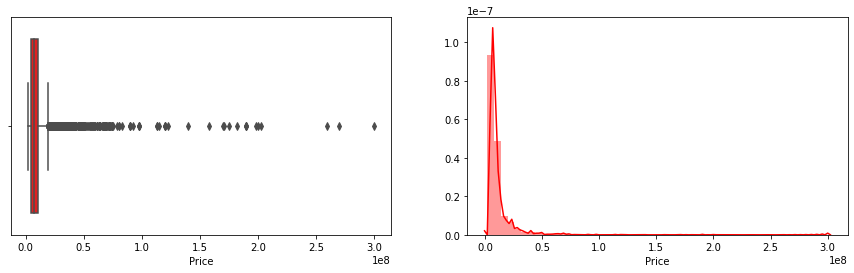

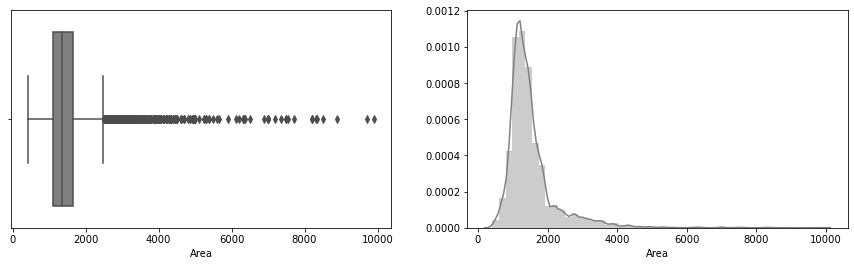

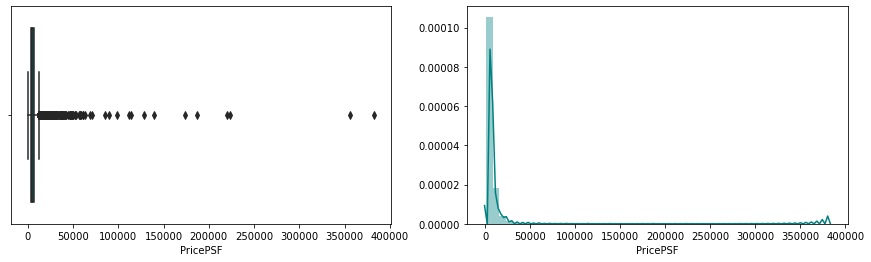

In [12]:
def dist_plot (feature, color, position=121):
    plt.figure(figsize=(15,4))
    plt.subplot(position)
    sns.boxplot(x=feature, data=bangalore, color=color)
    plt.subplot(position+1)
    sns.distplot(bangalore[feature], color=color)
dist_plot('Price', 'red')
dist_plot('Area', 'grey')
dist_plot('PricePSF', 'teal')

As we can see above, the data is <b>heavily right-skewed</b> for Price and Area both. One would expect that PricePSF would be normally distributed as it is a ratio, however it is not so. This indicates either or both of the following:

1. There is much more skewness in Price compared to Area
2. The houses with high Prices are not necessarily the ones with the large Area, hence PricePSF is not able to normalize such cases

We now proceed to <b>remove outliers</b> so that they don't have a lopsided impact on our model. As the data is heavily right skewed, we remove a higher percentile (10%) from the top versus bottom(5%)

In [13]:
# define outliers
price_psf_outliers = np.percentile(bangalore.PricePSF, [5,90])
price_outliers = np.percentile(bangalore.Price, [5,90])
area_outliers = np.percentile(bangalore.Area, [5,90])
# create filters based on outliers
price_psf_filter = (bangalore.PricePSF > price_psf_outliers[0]) & (bangalore.PricePSF < price_psf_outliers[1])
price_filter = (bangalore.Price > price_outliers[0]) & (bangalore.Price < price_outliers[1])
area_filter = (bangalore.Area > area_outliers[0]) & (bangalore.Area < area_outliers[1])
# apply filters
bangalore = bangalore[(price_psf_filter) & (price_filter) & (area_filter)]

Let us check the distribution again

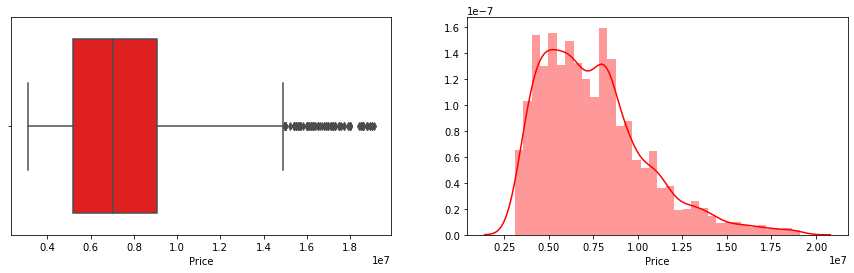

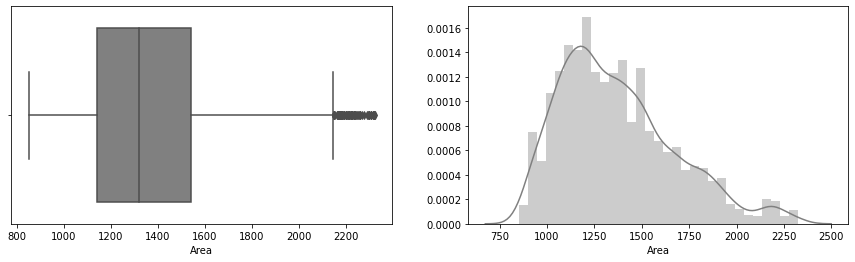

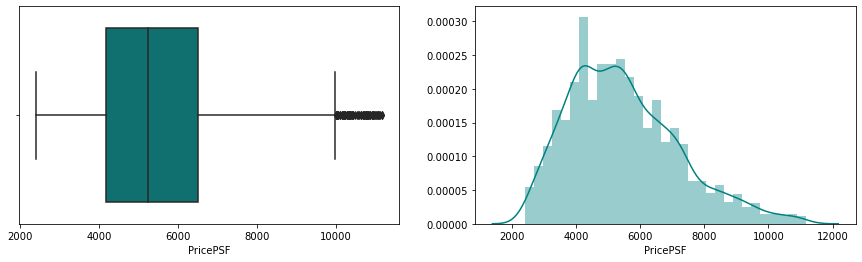

In [14]:
dist_plot('Price', 'red')
dist_plot('Area', 'grey')
dist_plot('PricePSF', 'teal')

The above distributions looks far better. Though there is still right-skewnesss, we can expect this from real estate prices as a small number of large size and expensive properties will pull the distribution to the right. 

<h3>Let us briefly discuss what drives a house price (longish read but important):</h3>

1. Area - Larger, would logically mean more expensive, all else held constant
2. Location - Factoring this requires knowledge of local area. We will try a workaround for this
3. Amenities - This is tricky. High rise apartment complexes will have lot of amenities compared to independent houses and villas. Yet they may be cheaper because all these amenities are shared. In the subsequent sections I have tried to create a 'FeatureScore' for amenities (higher FeatureScore should imply higher Price). However I admit that independent houses may lose out on this and the model may underprice such houses. I would welcome inputs on how to tackle this. 
4. Floor rise - In high rise complexes in India, houses on higher floors are priced higher by a linear formula. Floor data is absent from the data set.
5. Developer Reputation - Again this is very important in India. Two apartments in the same Location by developers of different repute have markedly different PricePSF. This information is absent from the data set. Even if it was available, one would require some local knowledge to factor in developer score. 
6. Resale or not - Another tricky one. In absence of the age of the house, only a Resale binary may not produce accurate results. A one year old resale versus 20 year old are very different. In some cases a 3-4 year resale may fetch a higher PricePSF as the complex would have matured and be niggle free, better landscaped etc.

<h3>As we can see, quite a few important variables are not available in the data set, hence our model may not perform very well on the test set</h3>

Let us now check the features available to us and also clean up the names so that they do not cause any problems later

In [16]:
bangalore.columns

Index([&#39;Unnamed: 0&#39;, &#39;Price&#39;, &#39;Area&#39;, &#39;Location&#39;, &#39;No. of Bedrooms&#39;, &#39;Resale&#39;,
       &#39;MaintenanceStaff&#39;, &#39;Gymnasium&#39;, &#39;SwimmingPool&#39;, &#39;LandscapedGardens&#39;,
       &#39;JoggingTrack&#39;, &#39;RainWaterHarvesting&#39;, &#39;IndoorGames&#39;, &#39;ShoppingMall&#39;,
       &#39;Intercom&#39;, &#39;SportsFacility&#39;, &#39;ATM&#39;, &#39;ClubHouse&#39;, &#39;School&#39;,
       &#39;24X7Security&#39;, &#39;PowerBackup&#39;, &#39;CarParking&#39;, &#39;StaffQuarter&#39;,
       &#39;Cafeteria&#39;, &#39;MultipurposeRoom&#39;, &#39;Hospital&#39;, &#39;WashingMachine&#39;,
       &#39;Gasconnection&#39;, &#39;AC&#39;, &#39;Wifi&#39;, &#39;Children&#39;splayarea&#39;, &#39;LiftAvailable&#39;,
       &#39;BED&#39;, &#39;VaastuCompliant&#39;, &#39;Microwave&#39;, &#39;GolfCourse&#39;, &#39;TV&#39;,
       &#39;DiningTable&#39;, &#39;Sofa&#39;, &#39;Wardrobe&#39;, &#39;Refrigerator&#39;, &#39;PricePSF&#39;],
      dt

Two columns seem to have problematic names. Let's rename them

In [17]:
bangalore.rename(columns={'No. of Bedrooms':'Bedrooms', "Children'splayarea":'PlayArea'}, inplace=True)

As we can see from the columns list, there are a lot of features, most of them binary. Most of the binary features will fit under the broad category of <b>Amenities</b>. In the following section I have tried to calculate feature scores for each house bases on the Amenities being absent or present. 

<b><u>Note: Important</u></b> - I have assigned weights to binary features based on my discretion. You are free to use the weights you want. I have also used a scale of 0-4 (0 being least important and 4 being most important). Again the choice of this scale is entirely up to you. 

In [18]:
# assign weights to features
feature_dict = {'MaintenanceStaff':2, 'Gymnasium':4, 'SwimmingPool':4,'LandscapedGardens':3, 'JoggingTrack':3, 'RainWaterHarvesting':2,'IndoorGames':3, 'ShoppingMall':2, 'Intercom':2, 'SportsFacility':3, 'ATM':2, 'ClubHouse':2, 'School':2, '24X7Security':1, 'PowerBackup':4, 'CarParking':3, 'StaffQuarter':0, 'Cafeteria':0, 'MultipurposeRoom':2, 'Hospital':3, 'WashingMachine':0, 'Gasconnection':2, 'AC':0, 'Wifi':0, 'PlayArea':3, 'LiftAvailable':0, 'BED':0, 'VaastuCompliant':0, 'Microwave':0, 'GolfCourse':0, 'TV':0, 'DiningTable':0, 'Sofa':0, 'Wardrobe':0, 'Refrigerator':0}

In [76]:
# convert to Dataframe
features = pd.DataFrame(feature_dict.items(), columns=['Features', 'Weight'])

In [24]:
features.head()

,Features,Weight
0,MaintenanceStaff,2
1,Gymnasium,4
2,SwimmingPool,4
3,LandscapedGardens,3
4,JoggingTrack,3


In [26]:
# The features matrix has 35 features
features.shape

(35, 2)

To arrive at Feature Score for each house, we need to calculate dot product between the features matrix and the features binaries. Before this, we need to <b><u>subset a features matrix</u></b> from the bangalore dataset

In [27]:
features_matrix = bangalore[['MaintenanceStaff', 'Gymnasium', 'SwimmingPool',
       'LandscapedGardens', 'JoggingTrack', 'RainWaterHarvesting',
       'IndoorGames', 'ShoppingMall', 'Intercom', 'SportsFacility', 'ATM',
       'ClubHouse', 'School', '24X7Security', 'PowerBackup', 'CarParking',
       'StaffQuarter', 'Cafeteria', 'MultipurposeRoom', 'Hospital',
       'WashingMachine', 'Gasconnection', 'AC', 'Wifi', 'PlayArea',
       'LiftAvailable', 'BED', 'VaastuCompliant', 'Microwave',
       'GolfCourse', 'TV', 'DiningTable', 'Sofa', 'Wardrobe',
       'Refrigerator']]

In [28]:
features_matrix.tail()

,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,JoggingTrack,RainWaterHarvesting,IndoorGames,ShoppingMall,Intercom,SportsFacility,...,LiftAvailable,BED,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator
6201,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6203,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6204,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6205,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9
6206,9,9,9,9,9,9,9,9,9,9,...,9,9,9,9,9,9,9,9,9,9


Some examination (not shown here) revelas that the features matrix contains (0, 1, 9) as values. I would assume that 9 represents NaN. Let us replace all 9s by 0s

In [29]:
features_matrix.replace(9, 0, inplace=True)

In [30]:
features_matrix.shape

(4453, 35)

We will now compute <b>dot product</b> between the "features_matrix" <b>(shape = 4453 x 35)</b> and 'Weight' column of the "features" dataframe <b>(shape = 35 x 1)</b>. This will result in a column vector of shape <b>4453 x 1</b> and is nothing but the FeatureScore for each house. We will then join this resulting vector with the bangalore dataframe

In [31]:
# apply dot product to compute feature score for every row
feature_scores_df = np.dot(features_matrix, features['Weight'])

In [32]:
# join feature scores column with bangalore dataframe
bangalore['FeatureScore'] = feature_scores_df

In [33]:
bangalore.head(3)

,Unnamed: 0,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,...,VaastuCompliant,Microwave,GolfCourse,TV,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore
1,1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,...,1,0,0,0,0,0,0,0,7548.325359,37
2,2,4866000,1179,Kannur on Thanisandra Main Road,2,0,0,1,1,1,...,0,0,0,0,0,0,0,0,4127.226463,22
3,3,8358000,1675,Doddanekundi,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4989.850746,6


We have now reduced the number of features on which to run our regression model. These are:

1. Area (numeric)
2. Location (string). In next section I will propose a way to tackle this. 
3. Bedrooms (numeric)
4. Feature Score (numeric)
4. Resale (boolean)

<b>Before we proceed let us check if our numerical features have any colinearity</b>

&lt;matplotlib.axes._subplots.AxesSubplot at 0x11cfa99d0&gt;

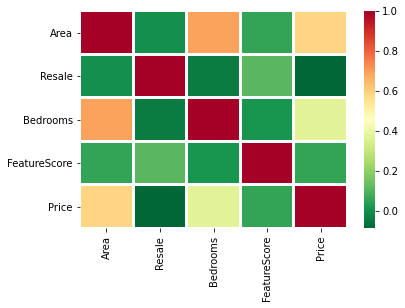

In [38]:
corr_df = bangalore[['Area', 'Resale', 'Bedrooms', 'FeatureScore', 'Price']]
sns.heatmap(corr_df.corr(method='pearson'), cmap='RdYlGn_r', linewidths=2)

<h3>Observations</h3>

1. We can see that <b>Area and Bedrooms are somewhat correlated</b>. This is not surprising as houses with larger area will tend to have more bedrooms and vice versa.
2. Area has a stronger correlation with Price compared to Bedrooms. If forced to make a choice, we should drop bedrooms to avoid colinearity
3. Interestingly FeatureScore does not seem to be correlated to Price. However, remember that the feature weights were my arbitrary choice and may be wrong. An industry expert can help here. For this analysis we will retain FeatureScore in our model

<h3>Let us now explore how we can model Location as a numeric feature</h3>

In [39]:
# Create a pivot table of Locations with PricePSF as the value
location_pivot = pd.pivot_table(data=bangalore, index='Location', aggfunc='mean', values='PricePSF')

In [41]:
location_pivot

,PricePSF
Location,
5th Phase,5327.547721
5th Stage BEML Layout,5527.356322
5th Stage Raja Rajeshwari Nagar,4727.549774
6th phase jp nagar,5226.666667
8th Phase JP Nagar,6221.070320
...,...
Yelahanka New Town,2766.956522
Yerthiganahalli,7691.522763
Yeshwantpur,5424.059214


<b>Location is one of the most important determinants of house price</b>. As a bit of feature engineering, I am going to calculate the 'Location Premium' for every Location. This is nothing but the PricePSF for every location divided by the minimum PricePSF. This sets the cheapest location as the base location (with a score of 1) and every other location has a premium as a multiple of that base location 

In [42]:
location_pivot['LocationPremium'] = location_pivot['PricePSF'] / location_pivot['PricePSF'].min()

In [43]:
location_pivot.sort_values('LocationPremium', ascending=False)

,PricePSF,LocationPremium
Location,,
Volagerekallahalli,10771.889401,4.362553
Bannerughatta,9684.684685,3.922242
Frazer Town,9545.454545,3.865854
Hoskote,9403.107114,3.808204
BTM Layout,9017.580859,3.652068
...,...,...
Sompura Gate,2689.843217,1.089371
Nagawara,2583.586626,1.046338
Ashoka Road,2555.555556,1.034985


We now merge the location pivot with the bangalore dataframe on 'Location' column

In [79]:
bangalore = pd.merge(bangalore, location_pivot['LocationPremium'], on='Location')

As a final step we calculate the <b>log</b> of LocationPremium. I observed that it yields better results than simply using LocationPremium

In [80]:
bangalore['LogPremium'] = np.log(bangalore['LocationPremium'])

In [81]:
# check if all required columns are present
bangalore.head(3)

,Unnamed: 0,Price,Area,Location,Bedrooms,Resale,MaintenanceStaff,Gymnasium,SwimmingPool,LandscapedGardens,...,DiningTable,Sofa,Wardrobe,Refrigerator,PricePSF,FeatureScore,LocationPremium_x,LogPremium,LocationPremium_y,LocationPremium
0,1,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,...,0,0,0,0,7548.325359,37,2.552363,0.93702,2.552363,2.552363
1,19,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,...,0,0,0,0,7548.325359,37,2.552363,0.93702,2.552363,2.552363
2,39,7888000,1045,Dasarahalli on Tumkur Road,2,0,0,1,1,1,...,0,0,0,0,7548.325359,37,2.552363,0.93702,2.552363,2.552363


<b>We are now ready to prepare our Linear Regression Model</b>

In [50]:
x = bangalore[['Area', 'FeatureScore', 'Resale', 'LogPremium', 'Bedrooms']]
y = bangalore['Price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=19)

<b>I used Statsmodel to run the regression as it yields a useful summary which is not provided by ScikitLearn</b>

In [53]:
model = sm.OLS(y_train, x_train).fit()
model.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.923
Method:                 Least Squares   F-statistic:                              8506.
Date:                Wed, 30 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:14:05   Log-Likelihood:                         -57163.
No. Observations:                3562   AIC:                                  1.143e+05
Df Residuals:                    3557   BIC:                                  1.144e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P&gt;|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Area          4775.6753    176.260     27.095      0.000    4430.095    5121.255
FeatureScore  4009.2513   2391.683      1.676      0.094    -679.957    8698.460
Resale       -9.644e+05   1.39e+05     -6.943      0.000   -1.24e+06   -6.92e+05
LogPremium     4.31e+06   1.91e+05     22.621      0.000    3.94e+06    4.68e+06
Bedrooms      -8.98e+05   9.05e+04     -9.925      0.000   -1.08e+06   -7.21e+05
==============================================================================
Omnibus:                      451.081   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              735.811
Skew:                           0.870   Prob(JB):                    1.66e-160
Kurtosis:                       4.388   Cond. No.                     7.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
&quot;&quot;&quot;

<h3>Observations</h3>

1. R squared value of 92.3% is good. However, we are yet to see how the model performs on test data
2. Feature Score has a p-value of greater than 0.05, indicating that it is not an important determinant of price. Either that or I have not engineered it well.
3. FeatureScore also has a very high range (even entering negative territory). Clearly there is much more to be engineered here as presence of even a single feature should not reduce the price of a house.
4. Bedrooms has a negative coefficient, indicating more bedrooms lower the price. This seems like an anomaly and is a likely result of colinearity between bedrooms and Area. If modeled in the absense of Area, Bedrooms may result in a positive correlation.
5. 'Resale = True' negatively impacts the price, which is understandable. However the extent (almost a million Rupees) may be a subject for further analysis for industry experts

<b>Let us now see how the model performs on test data</b>

Text(0, 0.5, &#39;Predicted Test Prices&#39;)

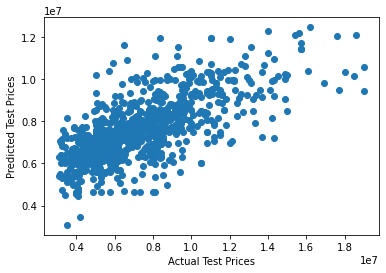

In [64]:
predictions = model.predict(x_test)
plt.scatter(x=y_test, y=predictions)
plt.xlabel('Actual Test Prices')
plt.ylabel('Predicted Test Prices')

Although there seems to be a linear correlation between test set Prices and predicted Prices, there is also a fair bit of scatter. Let us check the residuals plot

Text(0.5, 0, &#39;Residuals&#39;)

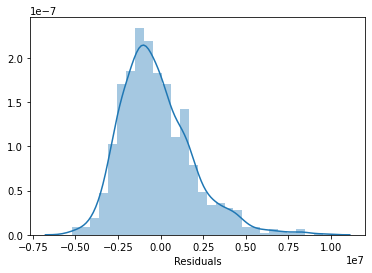

In [62]:
residuals = y_test - predictions
sns.distplot(residuals)
plt.xlabel('Residuals')

The residuals seem to be mostly normally distributed, except for a slight skew to the right. Residuals bordering on close to Rs 10 million are problematic. Let us now check the plot of residuals against predicted prices

Text(0, 0.5, &#39;Residuals&#39;)

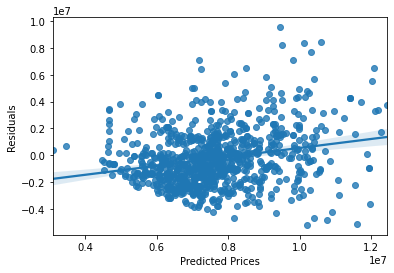

In [61]:
sns.regplot(x=predictions, y=residuals)
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')

In [69]:
mean_absolute_error(y_test,predictions)

1658513.787400134

In [70]:
predictions.mean()

7638996.812303056

<h3>Observations</h3>

1. The residuals-predictions plot has a somewhat funnel/cone shape towards the right, indicating Heteroscadasticity. This is to be expected in housing prices as they do not vary uniformly. Houses which are very large or very small tend to be in short supply and hence command a higher PricePSF compared to commonly available sizes. 
2. For higher prices our model makes larger errors. I had expected this
3. The residuals seem to be distributed almost equally on both sides of the straight line, indicating that our model over predicts and under predicts almost equally
4. Mean absolute error of Rupees 1.65 million looks high for a range of values which has a mean of Rs 7.64 million

Let us run our model once again, this time excluding Bedrooms as a predictor. Despite evidence against FeatureScore, I am retaining it as I am not fully convinced that features don't have an impact

In [67]:
x2 = bangalore[['Area', 'FeatureScore', 'Resale', 'LogPremium']]
y2 = bangalore['Price']
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=19)

In [68]:
model2 = sm.OLS(y_train2, x_train2).fit()
model2.summary()

&lt;class &#39;statsmodels.iolib.summary.Summary&#39;&gt;
&quot;&quot;&quot;
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                          1.032e+04
Date:                Wed, 30 Sep 2020   Prob (F-statistic):                        0.00
Time:                        19:41:33   Log-Likelihood:                         -57212.
No. Observations:                3562   AIC:                                  1.144e+05
Df Residuals:                    3558   BIC:                                  1.145e+05
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P&gt;|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Area          3388.6663    108.878     31.124      0.000    3175.197    3602.135
FeatureScore  3943.2027   2424.225      1.627      0.104    -809.807    8696.213
Resale       -9.044e+05   1.41e+05     -6.430      0.000   -1.18e+06   -6.29e+05
LogPremium    3.898e+06   1.88e+05     20.680      0.000    3.53e+06    4.27e+06
==============================================================================
Omnibus:                      502.762   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              827.245
Skew:                           0.952   Prob(JB):                    2.32e-180
Kurtosis:                       4.397   Cond. No.                     6.91e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.91e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
&quot;&quot;&quot;

<h3>Observations</h3>

1. The R-squared value is almost unchanged, but what is important to see is that the coefficient for Area has reduced. I like this because to me this coefficient represents the cost of construction and it is now closer to the real value (the cost of construction in India varies from Rupees 2500-3500 per square feet). This should be similar for all houses regardless of area and the premium should actually be derived from the Location
2. The p-value of FeatureScore has increased, indicating it is even less important in this second model

<b>Let us make predictions using model2</b>

In [72]:
predictions2 = model2.predict(x_test2)

I am skipping the plots and only concerning myself with the mean squared error for the time being

In [73]:
mean_absolute_error(y_test2,predictions2)

1673776.9146240733

In [74]:
predictions2.mean()

7658133.838335059

<h2>Concluding Remarks</h2>

1. Model2 does not seem to be performing better than Model1 on test data.
2. However, I do believe that Model2 does better than Model1 in assigning a lower coefficient to Area for reasons explained earlier
3. Also as noted earlier, significant drivers of Price such as Developer reputation and Age of house are not available in the data set and these may impact the predictions
4. Location Premium uses PricePSF in its calculation, which in turn uses Price, which is the dependent variable. I am not sure if and how much this impacts the model. Conceptually I need to study the impact of using a dependent variable in Feature Engineering
5. Independent Houses / Villas need a separate label from high rise apartments as their pricing structure is significantly different, namely apartments have a lower component of land value in their pricing due to shared land. However in absense of such a label we have to live with ambiguity
6. Domain/Industry expertise is very important and this is what helps in fine tuning parameters as well as identifying outliers and anomalies. 

<h3>I intend to run the model with similar assumptions on the Mumbai dataset. Mumbai as a housing market has virtually no independent houses and I would love to see if Amenities (Represented by FeatureScore) plays a more important role there. Thanks for Reading :)</h3>